# Import bibliotek

In [11]:
import json
import string
import numpy as np
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
import pandas as pd
import operator as op
import itertools as iter
from nltk.util import ngrams
from wordcloud import WordCloud
from matplotlib import pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.corpus import PlaintextCorpusReader
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/piotrgrochala/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/piotrgrochala/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


# Korpus dokumentów 

Scapowanie artykułów z wikipedii z 5 tematyk: kulinaria, uczenie maszynowe, głębokie uczenie, sport, astronomia

In [96]:
import requests
from bs4 import BeautifulSoup

subjects = ["Pierogi", "Bigos", "Chleb", "Żur", "Uczenie_maszynowe", "Analiza_skupień", "Regresja_liniowa", "Drzewo_decyzyjne", "Uczenie_głębokie", "Konwolucyjna_sieć_neuronowa", "Rekurencyjna_sieć_neuronowa", "Piłka_nożna", "Piłka_siatkowa", "Koszykówka", "Skoki_narciarskie", "Układ_Słoneczny", "Gwiazda", "Planeta", "Galaktyka"]

for s in subjects:
    url = f"https://pl.wikipedia.org/wiki/{s}"
    r = requests.get(url)
    html = r.text




    soup = BeautifulSoup(html, "html.parser")
    paragraphs = soup.find_all("p")
    text = "\n\n".join(p.get_text() for p in paragraphs)

    with open(f"articles/{s}.txt", "w", encoding="utf-8") as f:
        f.write(text)



In [147]:
# corpus_dir = 'streszczenie_original/'
corpus_dir = 'articles/'
corpus = PlaintextCorpusReader(corpus_dir, '.*\.txt')
files_names = corpus.fileids()
files_names

['Analiza_skupień.txt',
 'Bigos.txt',
 'Chleb.txt',
 'Drzewo_decyzyjne.txt',
 'Galaktyka.txt',
 'Gwiazda.txt',
 'Konwolucyjna_sieć_neuronowa.txt',
 'Koszykówka.txt',
 'Pierogi.txt',
 'Piłka_nożna.txt',
 'Piłka_siatkowa.txt',
 'Planeta.txt',
 'Regresja_liniowa.txt',
 'Rekurencyjna_sieć_neuronowa.txt',
 'Skoki_narciarskie.txt',
 'Uczenie_głębokie.txt',
 'Uczenie_maszynowe.txt',
 'Układ_Słoneczny.txt',
 'Żur.txt']

# Wstępne przygotowanie dokumentów

In [148]:
documents = {}
for file in files_names:
    documents[file] = corpus.raw(file)
print(json.dumps(documents, indent=4, ensure_ascii=False))

{
    "Analiza_skupień.txt": "Grupowanie (analiza skupień, klasteryzacja) (ang. data clustering) – metoda nienadzorowanej (ang. unsupervised learning) klasyfikacji statystycznej. Jest to metoda dokonująca grupowania elementów we względnie jednorodne klasy. Podstawą grupowania w większości algorytmów jest podobieństwo pomiędzy elementami – wyrażone przy pomocy funkcji (metryki) podobieństwa.\n\n\nPoprzez grupowanie można również rozwiązać problemy z gatunku odkrywania struktury w danych oraz dokonywanie uogólniania. Grupowanie polega na wyodrębnianiu grup (klas, podzbiorów).\n\n\nWybrane cele dokonywania grupowania są następujące:\n\n\nPionierem analizy skupień był psycholog Robert Tryon.[1]\n\n\nGrupowanie jako jedna z metod pozyskiwania wiedzy, a tym samym eksploracji danych, jest ściśle uwarunkowana źródłem danych oraz oczekiwaną postacią rezultatów.\n\n\nAlgorytmy analizy skupień dzieli się na kilka podstawowych kategorii:\n",
    "Bigos.txt": "polska, litewska, białoruska\n\n\nPols

In [149]:
stoplist_file = open('stopwords_pl.txt', 'r', encoding='utf-8')
stoplist = stoplist_file.read().splitlines()
stoplist_file.close()
stoplist = stoplist[4:]
stoplist

['vol',
 'o.o.',
 'mgr',
 'godz',
 'zł',
 'www',
 'pl',
 'ul',
 'tel',
 'hab',
 'prof',
 'inż',
 'dr',
 'i',
 'u',
 'aby',
 'albo',
 'ale',
 'ani',
 'aż',
 'bardzo',
 'bez',
 'bo',
 'bowiem',
 'by',
 'byli',
 'bym',
 'był',
 'była',
 'było',
 'były',
 'być',
 'będzie',
 'będą',
 'chce',
 'choć',
 'co',
 'coraz',
 'coś',
 'czy',
 'czyli',
 'często',
 'dla',
 'do',
 'gdy',
 'gdyby',
 'gdyż',
 'gdzie',
 'go',
 'ich',
 'im',
 'inne',
 'iż',
 'ja',
 'jak',
 'jakie',
 'jako',
 'je',
 'jednak',
 'jednym',
 'jedynie',
 'jego',
 'jej',
 'jest',
 'jeszcze',
 'jeśli',
 'jeżeli',
 'już',
 'ją',
 'kiedy',
 'kilku',
 'kto',
 'która',
 'które',
 'którego',
 'której',
 'który',
 'których',
 'którym',
 'którzy',
 'lat',
 'lecz',
 'lub',
 'ma',
 'mają',
 'mamy',
 'mi',
 'miał',
 'mimo',
 'mnie',
 'mogą',
 'może',
 'można',
 'mu',
 'musi',
 'na',
 'nad',
 'nam',
 'nas',
 'nawet',
 'nic',
 'nich',
 'nie',
 'niej',
 'nim',
 'niż',
 'no',
 'nowe',
 'np',
 'nr',
 'o',
 'od',
 'ok',
 'on',
 'one',
 'oraz',
 '

In [150]:
import ctypes
lib_path = "/Users/piotrgrochala/Dokumenty-nwi/TextMining/.venv/lib/python3.9/site-packages/morfeusz2-1.99.8-py3-macosx-10.9-x86_64.egg/libmorfeusz2.dylib"
lib = ctypes.CDLL(lib_path)
print("Library loaded successfully!")


Library loaded successfully!


In [151]:
def lemmatize(text):
    morf = lib.morfeusz2.Morfeusz()
    segments = iter.groupby(morf.analyse(text), op.attrgetter(0,1))
    def disambiguate(group):
        pairs = ((len(descr), lemma) for _, _, (_, lemma, descr, _, _, )in group)
        perpl, lemma = min(pairs)
        return lemma.split(':')[0]
    lemmas = (disambiguate(group) for key, group in segments)
    return ' '.join(filter(str.isalpha, lemmas))


In [152]:
def lemmatize(text):
    from nltk.tokenize import word_tokenize
    tokens = word_tokenize(text, language="polish")
    # Return only alphabetic tokens.
    lemmas = [token for token in tokens if token.isalpha()]
    return " ".join(lemmas)

In [153]:
# morf = lib.morfeusz2.Morfeusz()
# morf.analyse("Ala ma kota")

In [154]:
for key in documents:
    documents[key] = documents[key].lower()
    documents[key] = "".join([char for char in documents[key] if char not in string.punctuation])
    documents[key] = lemmatize(documents[key])
    documents[key] = " ".join([word for word in word_tokenize(documents[key], language='polish') if word not in stoplist])
    

# Utworzenie macierzy częstości

In [155]:
docs = pd.DataFrame.from_dict(documents, orient='index')
docs.columns = ['content']
docs

content
Analiza_skupień.txt              grupowanie analiza skupień klasteryzacja ang d...
Bigos.txt                        polska litewska białoruska polska bigos starop...
Chleb.txt                        chleb pieczywo otrzymywane wypieku ciasta będą...
Drzewo_decyzyjne.txt             drzewo decyzyjne graficzna metoda wspomagania ...
Galaktyka.txt                    galaktyka gr γάλα gála mleko duży grawitacyjni...
Gwiazda.txt                      gwiazda kuliste ciało niebieskie stanowiące sk...
Konwolucyjna_sieć_neuronowa.txt  konwolucyjna sieć neuronowa splotowa sieć ang ...
Koszykówka.txt                   piłka koszykowa sport zespołowy cały świat kos...
Pierogi.txt                      wersja przejrzana strony min polska chińska wł...
Piłka_nożna.txt                  wersja przejrzana strony futbol międzynarodowa...
Piłka_siatkowa.txt               siatkówka międzynarodowa federacja piłki siatk...
Planeta.txt                      planeta ciało niebieskie obiekt astronomiczny ...
Regresja_liniowa.txt             regresja liniowa modelowaniu statystycznym met...
Rekurencyjna_sieć_neuronowa.txt  rekurencyjna sieć neuronowa ang recurrent neur...
Skoki_narciarskie.txt            międzynarodowa federacja narciarska snowboardo...
Uczenie_głębokie.txt             uczenie głębokie ang deep learning podkategori...
Uczenie_maszynowe.txt            uczenie maszynowe samouczenie maszyn systemy u...
Układ_Słoneczny.txt              układ słoneczny układ planetarny drodze mleczn...
Żur.txt                          żurek biały barszcz polska czechy zalewajka za...

In [156]:
count_vectorizer = CountVectorizer()
counts_tf = count_vectorizer.fit_transform(docs['content'])
counts_tf.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [157]:
tfidf_vectorizer = TfidfVectorizer()
counts_tfidf = tfidf_vectorizer.fit_transform(docs['content'])
counts_tfidf.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

# Chmury tagów

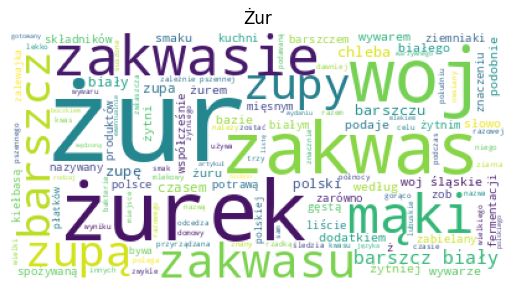

In [158]:
wordcloud = WordCloud(
    background_color='white',
    max_words=5000,
    contour_width=3,
    contour_color='steelblue',
)
for index, row in docs.iterrows():
    wordcloud.generate(row['content'])
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.title(index.replace('.txt', ''))
    plt.savefig(f'wordclouds/{index.replace(".txt", "")}.png', format='png')

# Topic modelling

In [159]:

def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(*subplots, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[-n_top_words:]
        top_features = feature_names[top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.savefig(f'topics/{title}.png', format='png')

In [160]:
n_components = 5
feature_names = count_vectorizer.get_feature_names_out()
n_top_features = 20
subplots = [1,5]


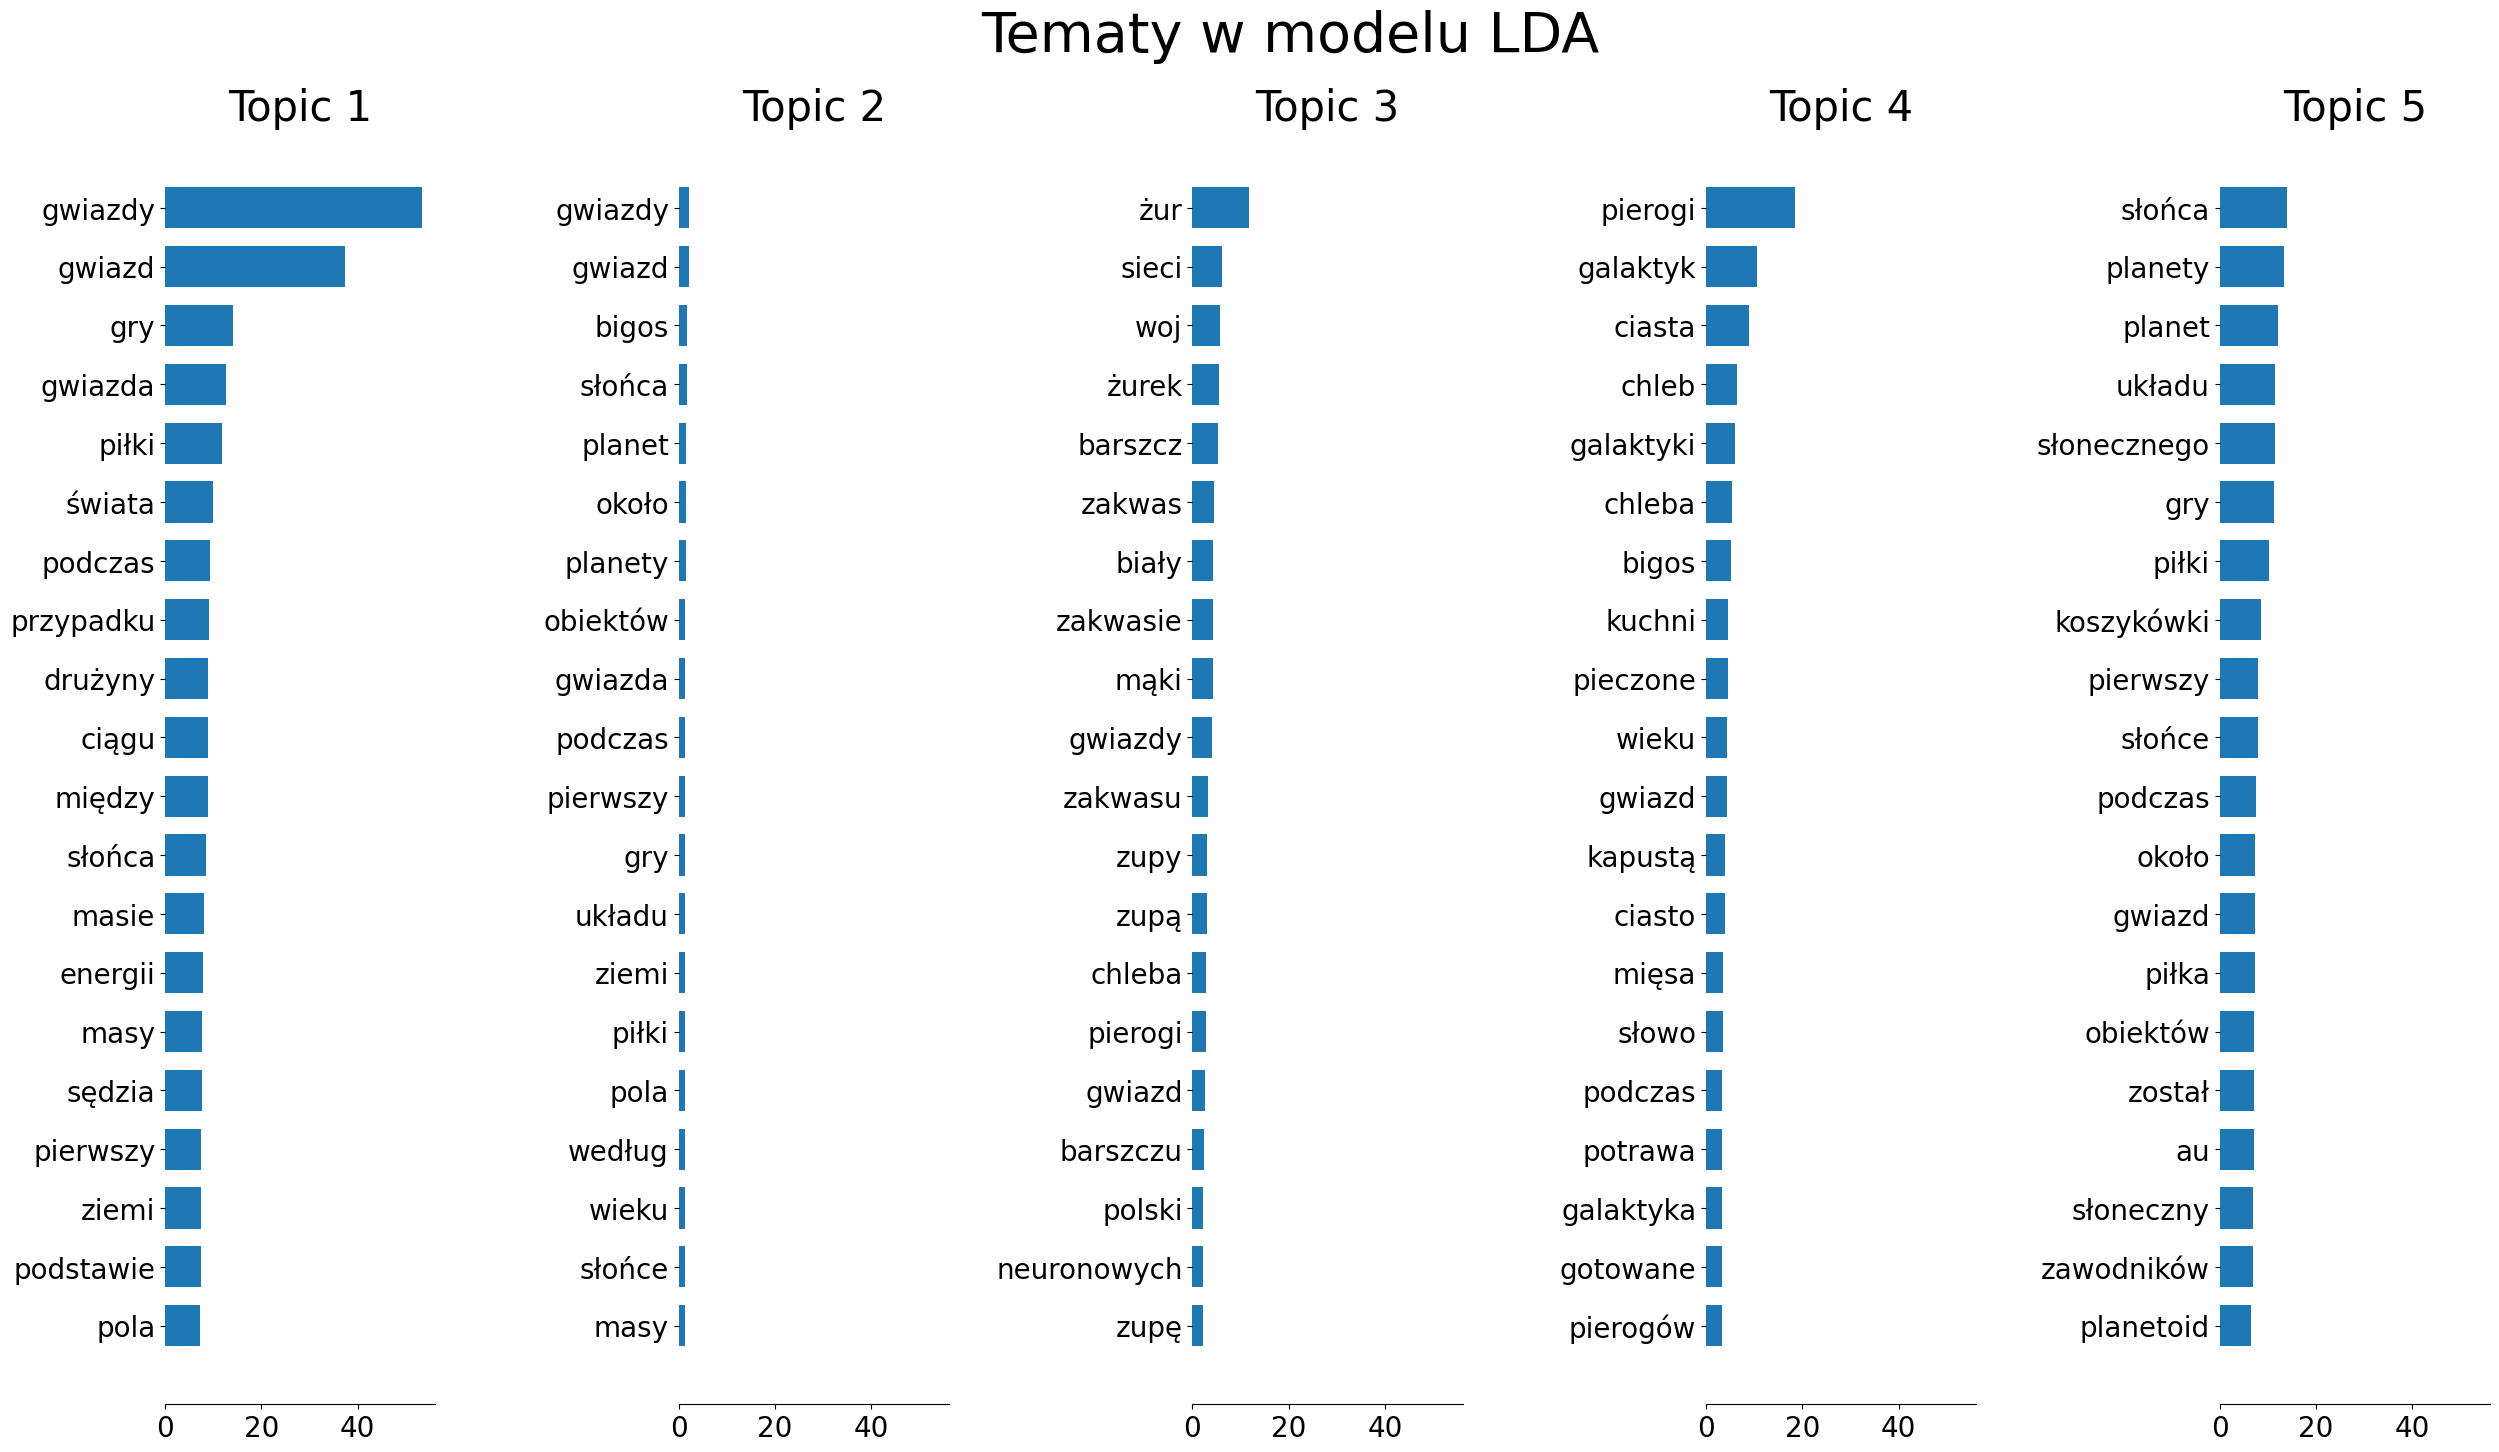

In [161]:
lda = LatentDirichletAllocation(
    n_components=n_components,
    max_iter=5,
    learning_method='online',
    learning_offset=50,
    random_state=0,
)
lda.fit(counts_tf)
plot_top_words(lda, feature_names, n_top_features, "Tematy w modelu LDA")

## Tematy w modelu LDA  
- **5 głównych obszarów tematycznych**: sport (gry, piłki, drużyny), astronomia (gwiazdy, słońca, planety), kulinaria (żur, barszcz, zakwas), kuchnia tradycyjna (pierogi, bigos, chleb) oraz fragmentaryczne „drugie” astronomiczne jądro (powiązane ze słowami z różnych dokumentów).  
- LDA faworyzuje najczęściej występujące słowa, dlatego pojawiają się zarówno terminy merytoryczne, jak i słowa funkcyjne („podczas”, „około”).  
- W niektórych „astronomicznych” i „sportowych” grupach widać mieszanie fraz z innych dziedzin – sugeruje to konieczność lepszego oczyszczenia korpusu.

Podsumowując model nie poradził sobie z kategoryzacją treści najlepiej


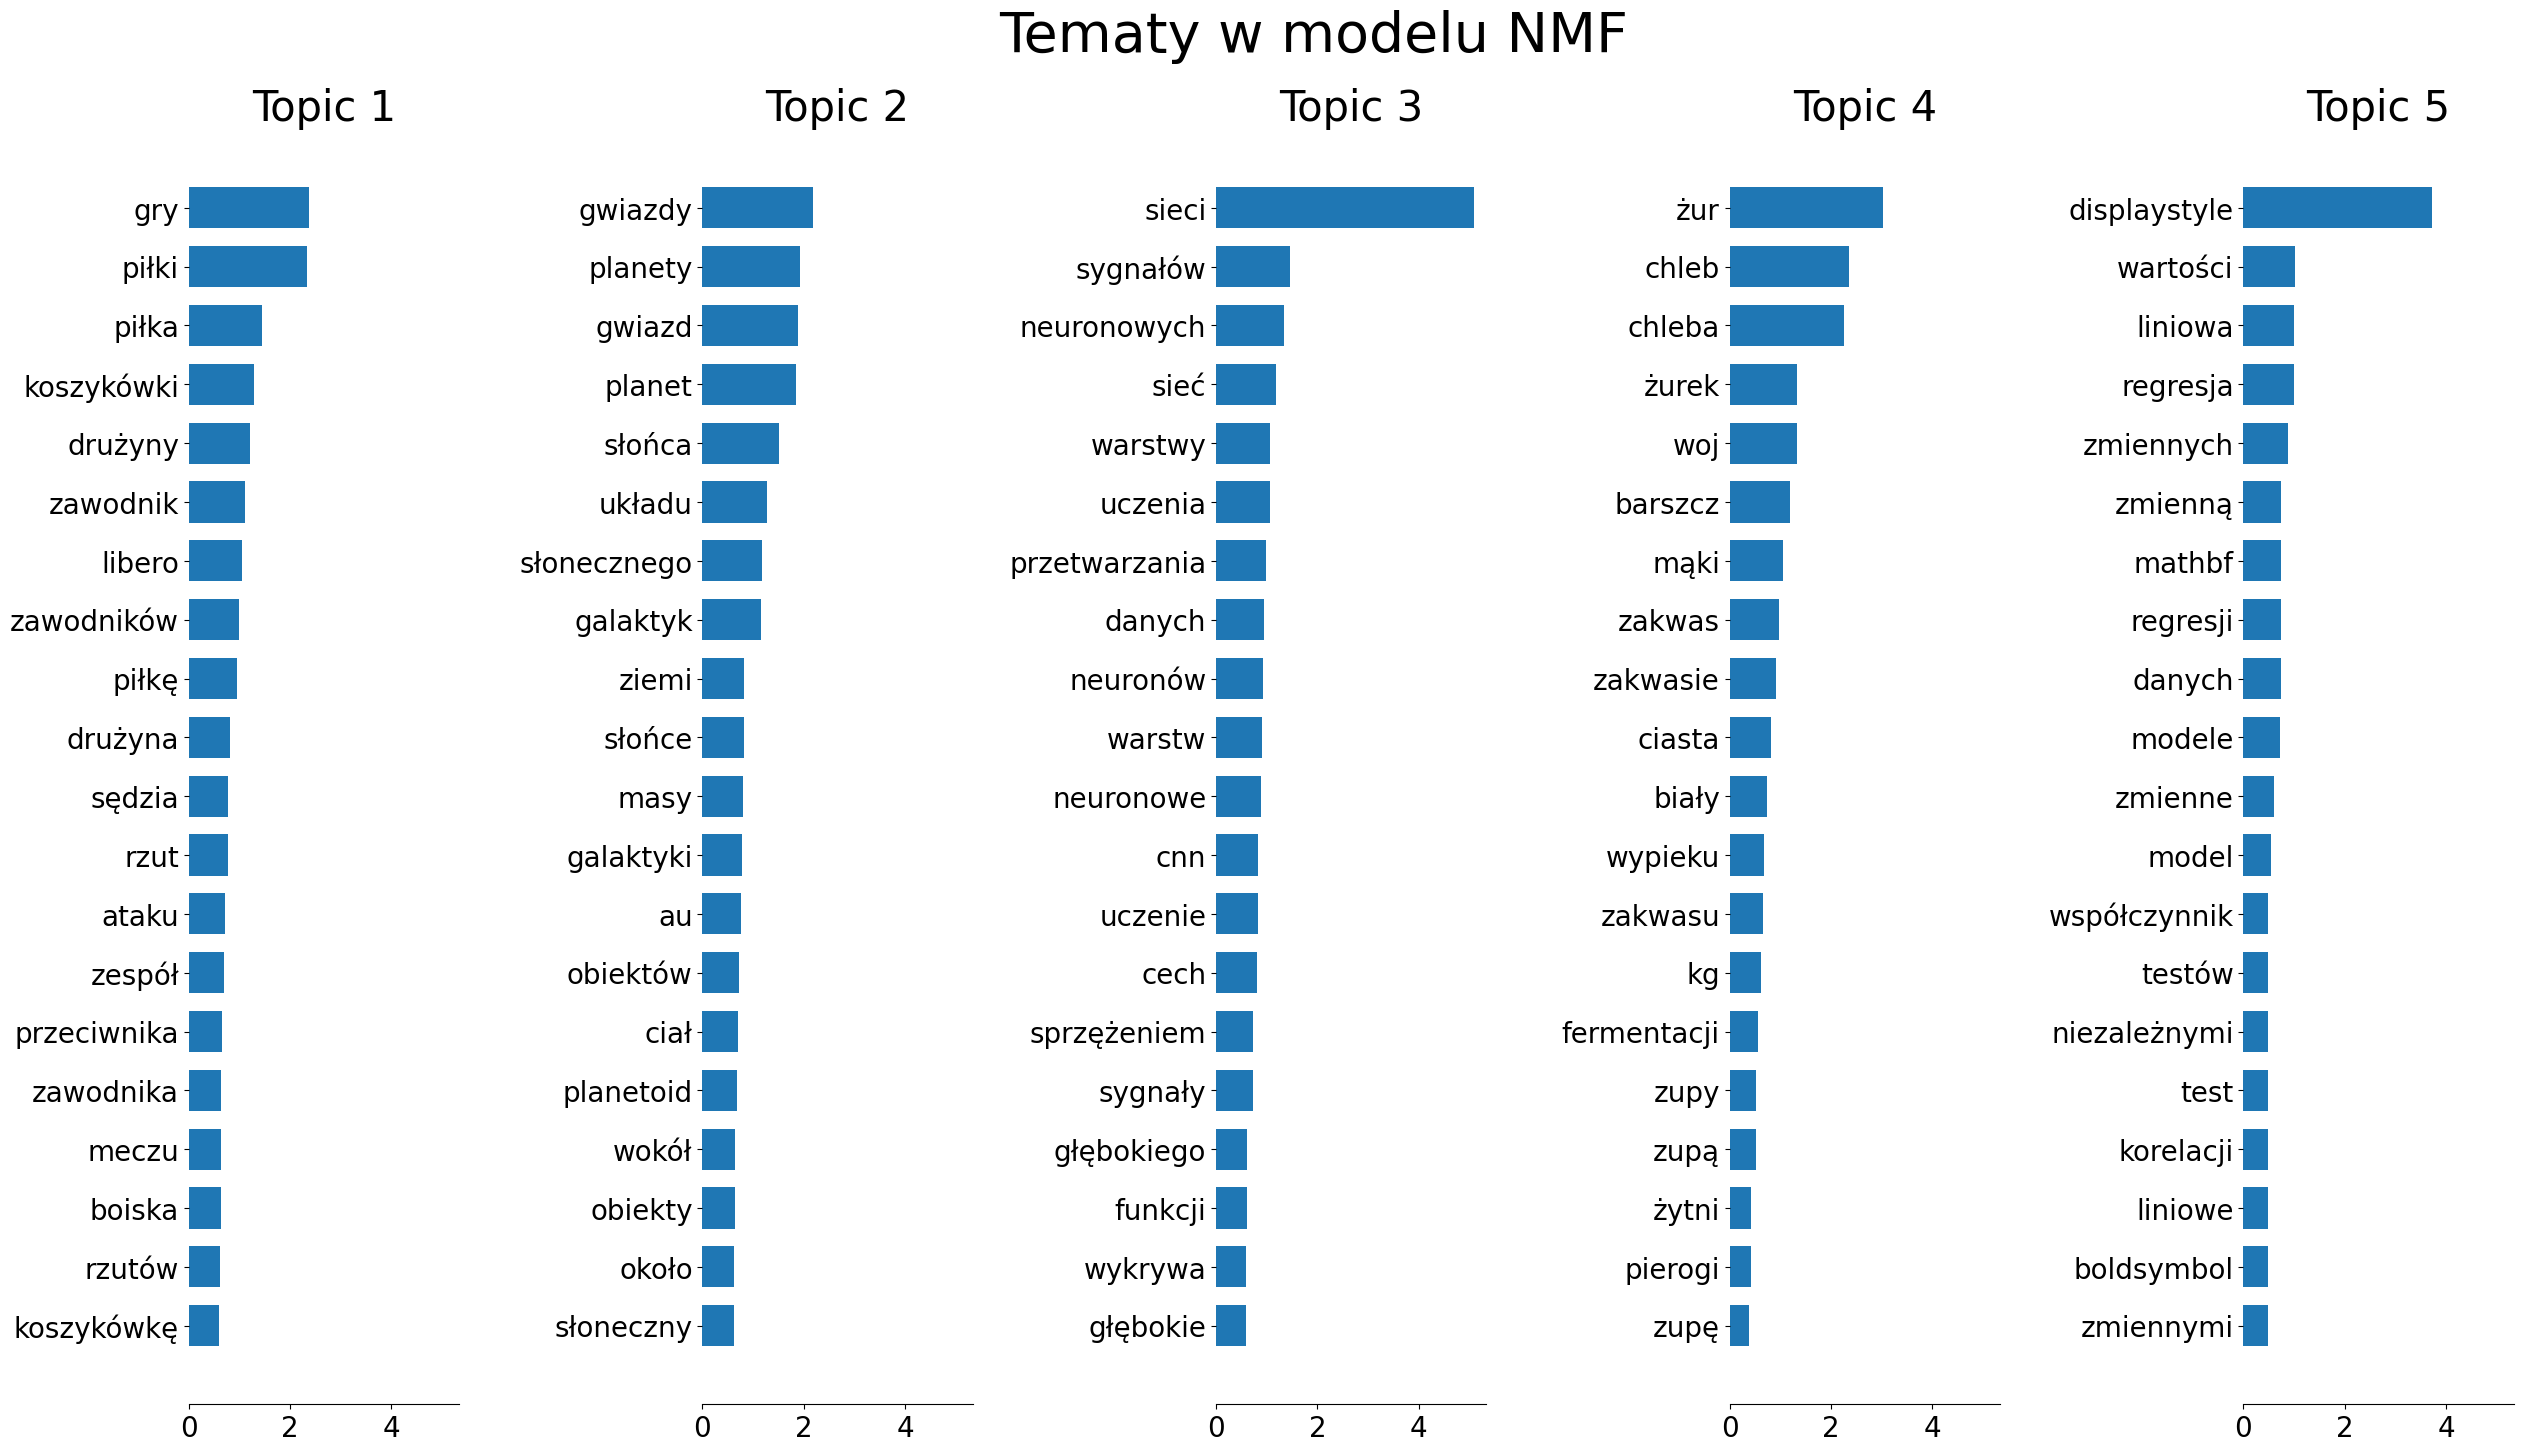

In [162]:
nmf_fm = NMF(
    n_components=n_components,
    random_state=1,
    alpha_H=0.00005,
    alpha_W=0.00005,
    l1_ratio=0.5,
)

nmf_fm.fit(counts_tfidf)
plot_top_words(nmf_fm, feature_names, n_top_features, "Tematy w modelu NMF")

## Tematy w modelu NMF_FM
- **Wyraźny podział na 5 tematów**:  
  1. Sport (gry, piłki, koszykówki, libero)  
  2. Astronomia (gwiazdy, planety, galaktyki)  
  3. Sieci neuronowe i uczenie (sieci, sygnałów, warstw, CNN)  
  4. Kulinaria (pierogi, bigos, chleb, kapusta)  
  5. Statystyka   
- **Czystość tematów**: każdy z pięciu obszarów jest dobrze rozdzielony, bez silnego „przecieku” fraz z innych dziedzin.

Podsumowując model poradził sobie bardzo dobrze z kategoryzacją tematów


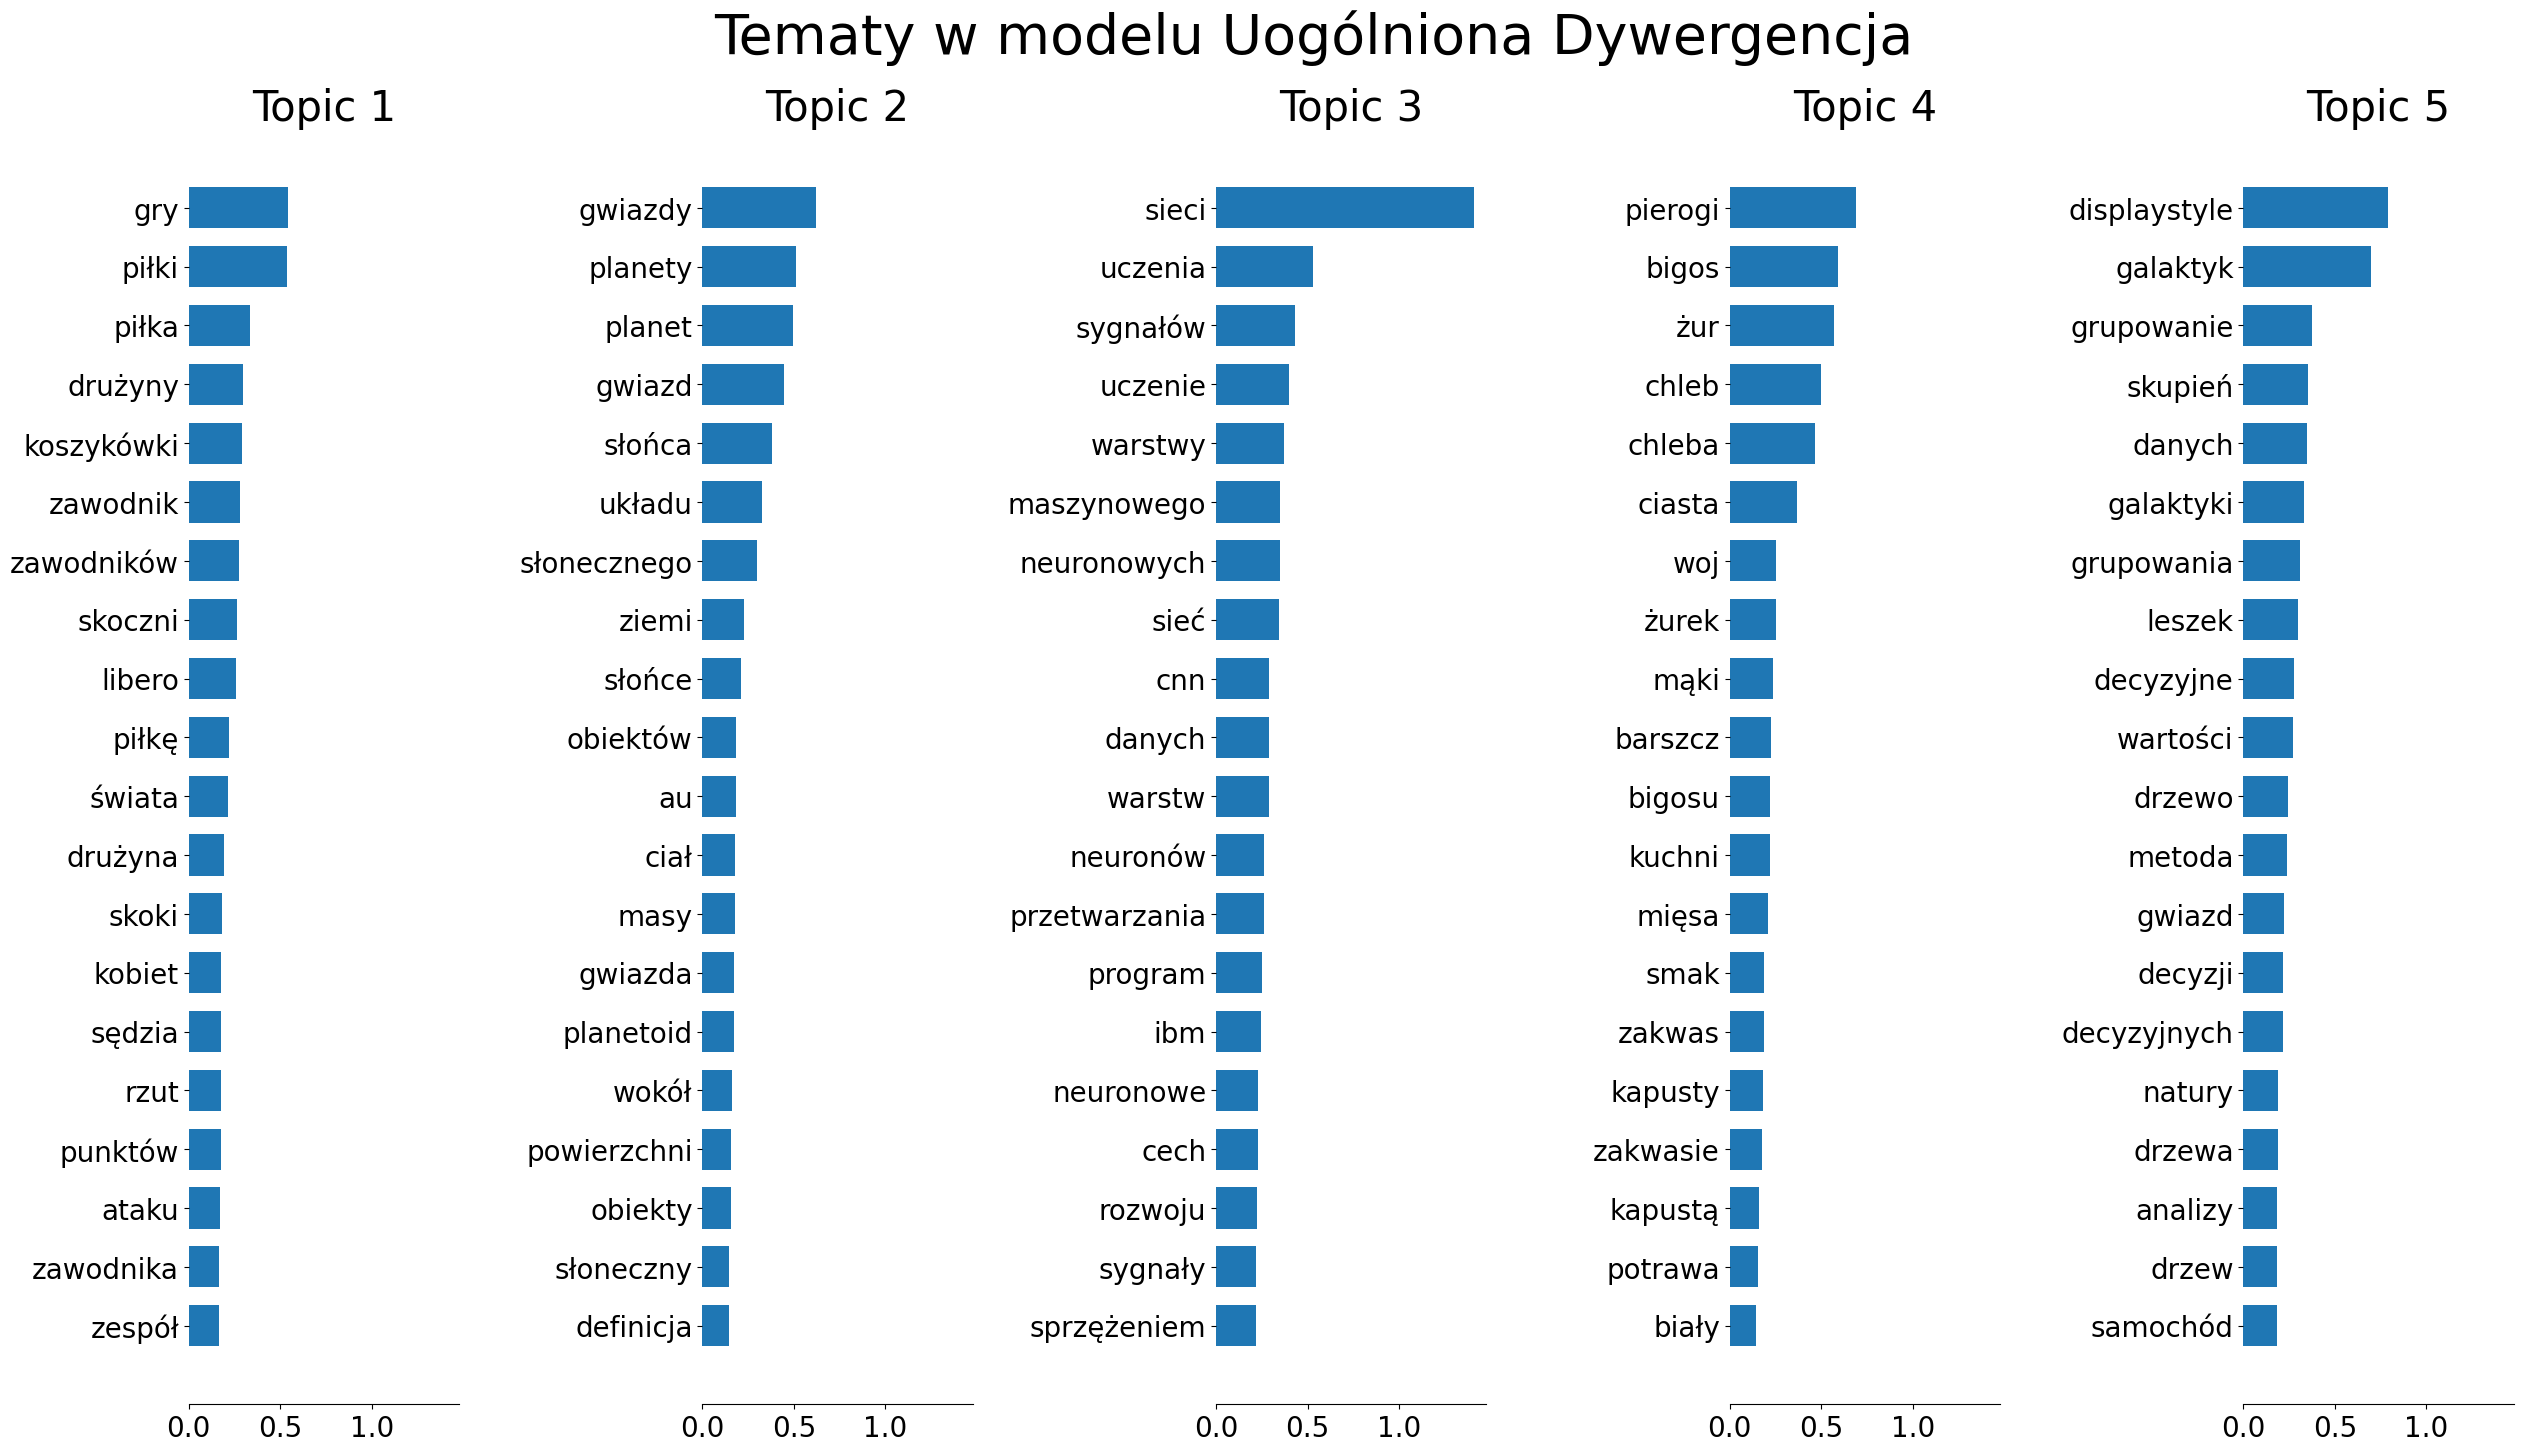

In [163]:
nmf_kl = NMF(
    n_components=n_components,
    random_state=1,
    beta_loss='kullback-leibler',
    solver='mu',
    max_iter=1000,
    alpha_H=0.00005,
    alpha_W=0.00005,
    l1_ratio=0.5,
)

nmf_kl.fit(counts_tfidf)
plot_top_words(nmf_kl, feature_names, n_top_features, "Tematy w modelu Uogólniona Dywergencja")

## Tematy w modelu NMF_KL  
- **Bardzo silne jednowątkowe profile**:  
  1. Sport  
  2. Astronomia  
  3. Deep learning / ML  
  4. Kuchnia  
  5. Drzewa decyzyjne i grupowanie  
- **Mniejszy rozkrok tematów**: dokumenty mają wyższą koncentrację w jednym dominującym temacie.

Podsumowując model poradził sobie bardzo dobrze z kategoryzacją tematów


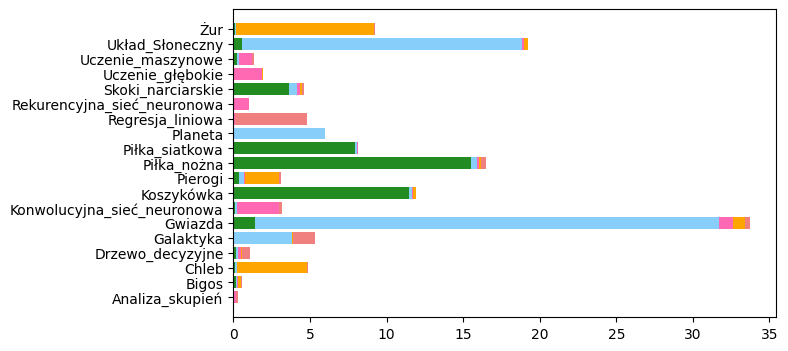

In [ ]:
docs_topics = pd.DataFrame(nmf_fm.transform(counts_tf), columns=['Topic 1', 'Topic 2', 'Topic 3', 'Topic 4', 'Topic 5'])
docs_topics.index = [file_name.replace('.txt', '') for file_name in files_names]
plt.figure(figsize=(7, 4))
colors = ['forestgreen', 'lightskyblue', 'hotpink', 'orange', 'lightcoral']
left = [0] * len(docs_topics)
for i, col in enumerate(docs_topics.columns):
    plt.barh(docs_topics.index, docs_topics[col], left=left, color=colors[i], label=col)
    left = [left[j] + docs_topics[col].iloc[j] for j in range(len(docs_topics))]
plt.show()

## Rozkład wag tematów w dokumentach (NMF klasyczny)  
- **Astronomia** („Gwiazda.txt”, „Układ_Słoneczny.txt”, „Planeta.txt”, "Galaktyka.txt") → wąski rozkład w temacie astronomicznym.  
- **Sport** („Piłka_nożna.txt”, „Piłka_siatkowa.txt”, „Koszykówka.txt”, "Skoki_narciarskie.txt") → dominacja tematu sportowego.  
- **ML/AI** („Uczenie_maszynowe.txt”, „Konwolucyjna_sieć_neuronowa.txt”…) → wysoki udział tematu sieci neuronowych.  
- **Kuchnia** („Pierogi.txt”, „Bigos.txt”, „Chleb.txt”, „Żur.txt”) → głęboka koncentracja w temacie kulinarnym.  
- **Wniosek**: klasyczny NMF poprawnie przypisuje każdy dokument do jednego lub maksymalnie dwóch głównych tematów.

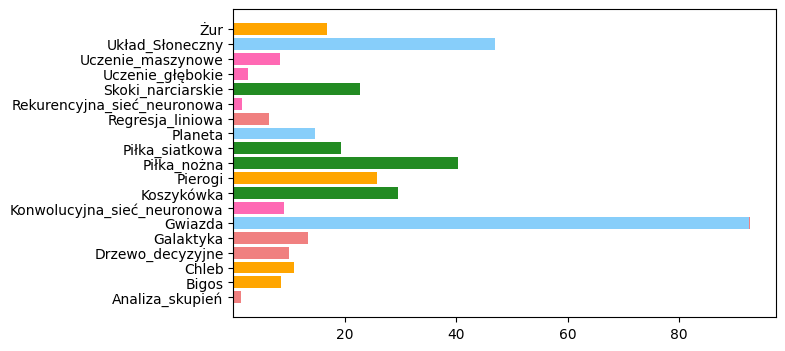

In [165]:
docs_topics = pd.DataFrame(nmf_kl.transform(counts_tf), columns=['Topic 1', 'Topic 2', 'Topic 3', 'Topic 4', 'Topic 5'])
docs_topics.index = [file_name.replace('.txt', '') for file_name in files_names]
plt.figure(figsize=(7, 4))
colors = ['forestgreen', 'lightskyblue', 'hotpink', 'orange', 'lightcoral']
left = [0] * len(docs_topics)
for i, col in enumerate(docs_topics.columns):
    plt.barh(docs_topics.index, docs_topics[col], left=left, color=colors[i], label=col)
    left = [left[j] + docs_topics[col].iloc[j] for j in range(len(docs_topics))]
plt.show()

## Rozkład wag tematów w dokumentach (NMF KL)  
- Ogólnie model klasyfikuje tematy bardzo dobrze, jedynie z pojedyńczymi przypadkami pomyłek (np. Galaktyka w temacie DL/ML)



# Analiza skupień

In [166]:
def plot_dendrogram(model, **kwargs):
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)
    dendrogram(linkage_matrix, **kwargs)

In [167]:
# cs = cosine_similarity(counts_tfidf, counts_tfidf).flatten().reshape(20,20)
# cs
cs = cosine_similarity(counts_tfidf)
print(cs.shape)                # (N, N)
cs_df = pd.DataFrame(cs,       # optional: nice row/col labels
                     index=files_names,
                     columns=files_names)
cs
cs_df


(19, 19)


Analiza_skupień.txt  Bigos.txt  Chleb.txt  \
Analiza_skupień.txt                         1.000000   0.001438   0.003514   
Bigos.txt                                   0.001438   1.000000   0.013696   
Chleb.txt                                   0.003514   0.013696   1.000000   
Drzewo_decyzyjne.txt                        0.027494   0.004629   0.011236   
Galaktyka.txt                               0.013113   0.006145   0.016758   
Gwiazda.txt                                 0.014768   0.017633   0.031003   
Konwolucyjna_sieć_neuronowa.txt             0.099066   0.004770   0.007954   
Koszykówka.txt                              0.007266   0.022905   0.019857   
Pierogi.txt                                 0.002003   0.081621   0.064575   
Piłka_nożna.txt                             0.011694   0.016024   0.019505   
Piłka_siatkowa.txt                          0.006904   0.012699   0.008741   
Planeta.txt                                 0.010263   0.012847   0.015318   
Regresja_liniowa.txt                        0.034496   0.004749   0.008370   
Rekurencyjna_sieć_neuronowa.txt             0.009154   0.002364   0.004857   
Skoki_narciarskie.txt                       0.007181   0.008691   0.014612   
Uczenie_głębokie.txt                        0.044722   0.003111   0.008309   
Uczenie_maszynowe.txt                       0.067959   0.009758   0.011086   
Układ_Słoneczny.txt                         0.016088   0.013616   0.027644   
Żur.txt                                     0.001468   0.038477   0.083136   

                                 Drzewo_decyzyjne.txt  Galaktyka.txt  \
Analiza_skupień.txt                          0.027494       0.013113   
Bigos.txt                                    0.004629       0.006145   
Chleb.txt                                    0.011236       0.016758   
Drzewo_decyzyjne.txt                         1.000000       0.017121   
Galaktyka.txt                                0.017121       1.000000   
Gwiazda.txt                                  0.029691       0.241400   
Konwolucyjna_sieć_neuronowa.txt              0.025600       0.016641   
Koszykówka.txt                               0.017697       0.016629   
Pierogi.txt                                  0.004433       0.010124   
Piłka_nożna.txt                              0.028718       0.020425   
Piłka_siatkowa.txt                           0.014595       0.014150   
Planeta.txt                                  0.014205       0.063139   
Regresja_liniowa.txt                         0.065109       0.096191   
Rekurencyjna_sieć_neuronowa.txt              0.011663       0.004553   
Skoki_narciarskie.txt                        0.016938       0.020784   
Uczenie_głębokie.txt                         0.012702       0.008390   
Uczenie_maszynowe.txt                        0.045003       0.007150   
Układ_Słoneczny.txt                          0.021218       0.148084   
Żur.txt                                      0.007760       0.005967   

                                 Gwiazda.txt  Konwolucyjna_sieć_neuronowa.txt  \
Analiza_skupień.txt                 0.014768                         0.099066   
Bigos.txt                           0.017633                         0.004770   
Chleb.txt                           0.031003                         0.007954   
Drzewo_decyzyjne.txt                0.029691                         0.025600   
Galaktyka.txt                       0.241400                         0.016641   
Gwiazda.txt                         1.000000                         0.048729   
Konwolucyjna_sieć_neuronowa.txt     0.048729                         1.000000   
Koszykówka.txt                      0.040282                         0.017437   
Pierogi.txt                         0.016837                         0.008593   
Piłka_nożna.txt                     0.047156                         0.028321   
Piłka_siatkowa.txt                  0.036562                         0.016440   
Planeta.txt                         0.163232               

In [168]:
clustering = AgglomerativeClustering(
    n_clusters=3,
    metric='euclidean',
    linkage='ward',
    compute_distances=True
).fit(cs)
clustering.labels_

array([0, 0, 0, 0, 2, 2, 0, 1, 0, 1, 1, 2, 0, 0, 0, 0, 0, 2, 0])

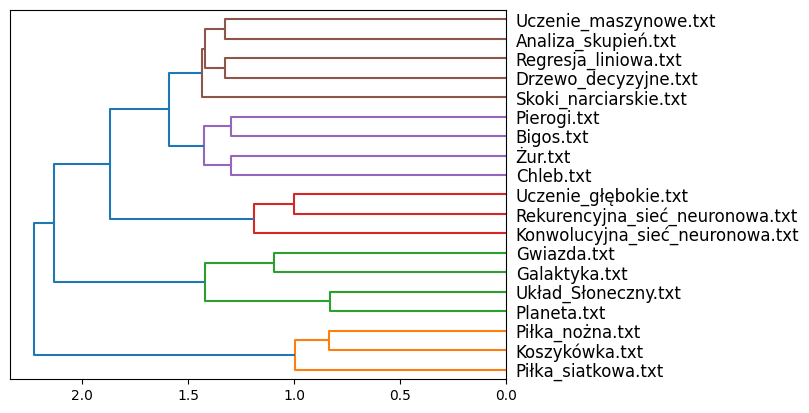

In [169]:
plot_dendrogram(
    clustering,
    labels = files_names,
    truncate_mode='level',
    orientation='left',
)
plt.show()

## Dendrogram 
- **Pięć klastrów**:  
  1. **ML/Statystyka** (uczenie maszynowe, regresja, drzewa decyzyjne, sieci neuronowe, skoki narciarskie)  
  2. **Kuchnia** (pierogi, bigos, żur, chleb)  
  3. **Astronomia** (gwiazda, galaktyka, układ słoneczny, planeta)  
  4. **Sport** (piłka nożna, koszykówka, siatkówka) 
  5. **DL** (uczenie głębokie, rekurencyjna sieć neuronowa, konwolucyjna sieć neuronowa) 

Model jak widać pomylił się najbardziej w sklasyfikowaniu skoków narciarkisch do uczenia maszynowego


In [170]:
# ed = euclidean_distances(counts_tf, counts_tf).flatten().reshape(20,20)
# ed

ed = euclidean_distances(counts_tf, counts_tf)
ed

array([[  0.        ,  37.85498646,  43.71498599,  38.28837944,
         60.8276253 , 334.00449099,  35.39774004,  99.33277405,
        101.27191121, 132.71774561,  72.71863585,  58.99152482,
         30.91924967,  15.5241747 ,  83.01807032,  20.54263858,
         32.07802986, 156.97770542,  75.96051606],
       [ 37.85498646,   0.        ,  55.06359959,  51.75905718,
         69.73521349, 334.82831421,  50.53711507, 103.75933693,
        102.97086967, 136.20205578,  79.83107165,  67.66830868,
         46.67976007,  38.02630668,  89.43712876,  40.60788101,
         47.4341649 , 160.05311618,  81.41867108],
       [ 43.71498599,  55.06359959,   0.        ,  55.81218505,
         72.40856303, 334.56538972,  54.82700065, 106.01886625,
        105.96697599, 137.65536677,  82.8794305 ,  70.85901495,
         51.39066063,  43.79497688,  91.6242326 ,  45.92385001,
         52.05766034, 160.32778923,  82.39538822],
       [ 38.28837944,  51.75905718,  55.81218505,   0.        ,
         69.856

In [182]:
clustering = AgglomerativeClustering(
    n_clusters=5,
    metric='precomputed',
    linkage='complete',
    compute_distances=True
).fit(ed)
clustering.labels_

array([1, 1, 1, 1, 1, 3, 1, 0, 4, 0, 1, 1, 1, 1, 1, 1, 1, 2, 1])

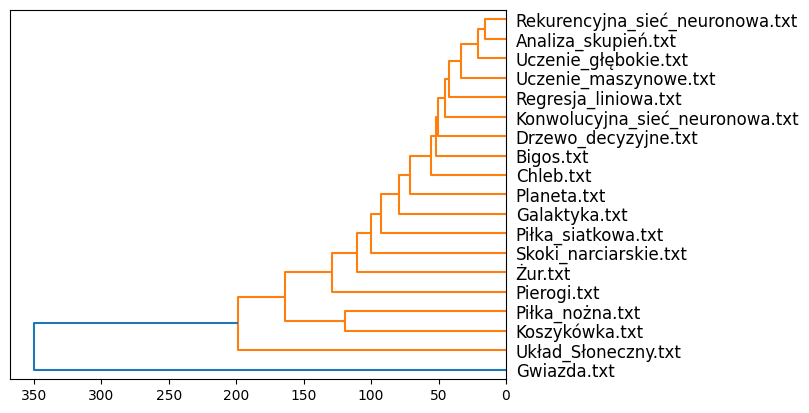

In [183]:
plot_dendrogram(
    clustering,
    labels = files_names,
    truncate_mode=None,
    orientation='left',
)
plt.show()

## Dendrogram 2 

Model podzielił dane na dwie grupy więc nie spenił swojej funkcji


# N-gramy

In [173]:
documents_tokenized = {}
for key in documents:
    documents_tokenized[key] = word_tokenize(documents[key], language='polish')
print(json.dumps(documents_tokenized, indent=4, ensure_ascii=False))

{
    "Analiza_skupień.txt": [
        "grupowanie",
        "analiza",
        "skupień",
        "klasteryzacja",
        "ang",
        "data",
        "clustering",
        "metoda",
        "nienadzorowanej",
        "ang",
        "unsupervised",
        "learning",
        "klasyfikacji",
        "statystycznej",
        "metoda",
        "dokonująca",
        "grupowania",
        "elementów",
        "względnie",
        "jednorodne",
        "klasy",
        "podstawą",
        "grupowania",
        "większości",
        "algorytmów",
        "podobieństwo",
        "pomiędzy",
        "elementami",
        "wyrażone",
        "pomocy",
        "funkcji",
        "metryki",
        "podobieństwa",
        "poprzez",
        "grupowanie",
        "rozwiązać",
        "problemy",
        "gatunku",
        "odkrywania",
        "struktury",
        "danych",
        "dokonywanie",
        "uogólniania",
        "grupowanie",
        "polega",
        "wyodrębnianiu",
        "g

In [174]:
for title in documents_tokenized:
    n_gram = pd.Series(ngrams(documents_tokenized[title], 3)).value_counts()
    print(list(ngrams(documents[title], 3)))
    print(n_gram[:5])

[('g', 'r', 'u'), ('r', 'u', 'p'), ('u', 'p', 'o'), ('p', 'o', 'w'), ('o', 'w', 'a'), ('w', 'a', 'n'), ('a', 'n', 'i'), ('n', 'i', 'e'), ('i', 'e', ' '), ('e', ' ', 'a'), (' ', 'a', 'n'), ('a', 'n', 'a'), ('n', 'a', 'l'), ('a', 'l', 'i'), ('l', 'i', 'z'), ('i', 'z', 'a'), ('z', 'a', ' '), ('a', ' ', 's'), (' ', 's', 'k'), ('s', 'k', 'u'), ('k', 'u', 'p'), ('u', 'p', 'i'), ('p', 'i', 'e'), ('i', 'e', 'ń'), ('e', 'ń', ' '), ('ń', ' ', 'k'), (' ', 'k', 'l'), ('k', 'l', 'a'), ('l', 'a', 's'), ('a', 's', 't'), ('s', 't', 'e'), ('t', 'e', 'r'), ('e', 'r', 'y'), ('r', 'y', 'z'), ('y', 'z', 'a'), ('z', 'a', 'c'), ('a', 'c', 'j'), ('c', 'j', 'a'), ('j', 'a', ' '), ('a', ' ', 'a'), (' ', 'a', 'n'), ('a', 'n', 'g'), ('n', 'g', ' '), ('g', ' ', 'd'), (' ', 'd', 'a'), ('d', 'a', 't'), ('a', 't', 'a'), ('t', 'a', ' '), ('a', ' ', 'c'), (' ', 'c', 'l'), ('c', 'l', 'u'), ('l', 'u', 's'), ('u', 's', 't'), ('s', 't', 'e'), ('t', 'e', 'r'), ('e', 'r', 'i'), ('r', 'i', 'n'), ('i', 'n', 'g'), ('n', 'g', ' 

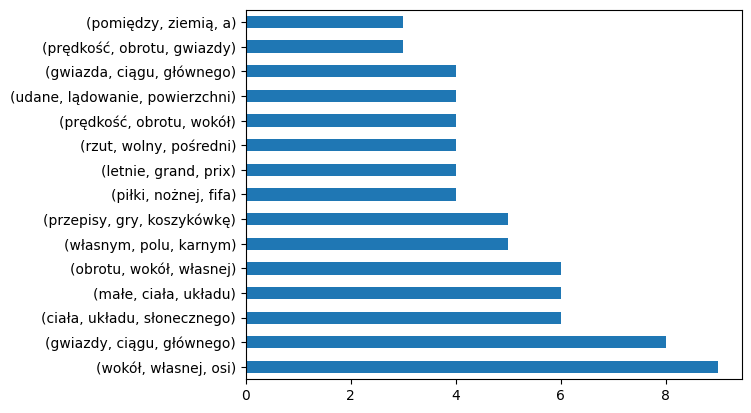

In [175]:
texts = ' '.join(docs['content']).split(' ')
n_gram = pd.Series(ngrams(texts, 3)).value_counts()
n_gram[:15].plot.barh()
plt.show()

## Najczęstsze 3-gramy w korpusie  
1. „(wokół, własnej, osi)”  
2. „(gwiazdy, ciągu, głównego)”  
3. „(ciała, układu, słonecznego)”  
4. „(piłki, nożnej, fifa)”  
5. „(przepisy, gry, koszykówkę)”  
6. „(udane, lądowanie, powierzchni)”